In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True):
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
            if len(self.train_img.shape)==3:
                new_shape = self.validation_img.shape + (1,)
                self.validation_img = self.validation_img.reshape(new_shape)

        
        if len(self.train_img.shape)==3:
            new_shape = self.train_img.shape + (1,)
            self.train_img = self.train_img.reshape(new_shape)
            new_shape = self.test_img.shape + (1,)
            self.test_img = self.test_img.reshape(new_shape)
        
        self.data_shape = self.train_img.shape
        
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        post_images = self.normalize(images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = self.train_img.shape[0]//batch_size
        for index in range(0, n_batches):
            x = self.train_img[index:index+batch_size, :, :, :]
            y = self.train_labels[index:index+batch_size]
            yield (x, y)

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)

        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))

In [4]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim, cmap):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, 0]
        plt.imshow(img, cmap=cmap)
    plt.show()

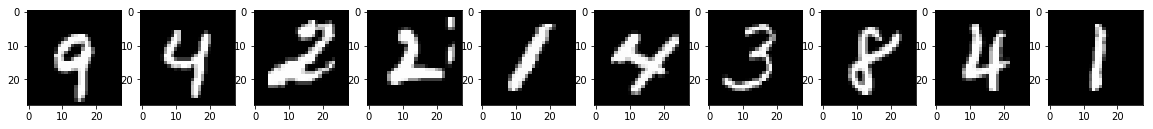

In [5]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

plot_images(plt_num=10, images=data.train_img, dim=20, cmap='gray')

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [7]:
def discriminator(images, reuse, alpha):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input Shape: (None, 28, 28, 1)
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # Conv layer.
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = leakyReLU(net, alpha)
        # Shape: (None, 16, 16, 64)
        
        # Conv layer.
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 8, 8, 128)

        net = tf.layers.flatten(net, name='flatten')
        # Shape: (None, 8*8*128)

        # Dense.
        net = tf.layers.dense(net, 1024, activation=None)
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense.
        logits = tf.layers.dense(net, 1, activation=None)
        # Shape: (None, 1)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [8]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Dense layer.
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense layer.
        net = tf.layers.dense(inputs=net, units=128*7*7, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 128*7*7)
        
        net = tf.reshape(net, (-1, 7, 7, 128))
        # Shape: (None, 7, 7, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        logits = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Shape: (None, 28, 28, 1)
        output = tf.nn.sigmoid(logits)
        
        return output

In [9]:
def show_generated(session, output_fake, n_images, z_input, image_type):
    cmap = None if image_type == 'RGB' else 'gray'
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    
    gen_samples *= 255.
    
    plot_images(plt_num=n_images, images=gen_samples, dim=10, cmap=cmap)    

In [10]:
def loss(real_images, z_input, out_channel_dim, alpha):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    dis_logits_diff = logits_real - logits_fake
    loss_dis = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_diff, labels=tf.ones_like(output_fake)))

    # Generator loss.
    gen_logits_diff = logits_fake - logits_real
    loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gen_logits_diff, labels=tf.ones_like(output_fake)))
    
    return loss_dis, loss_gen

In [11]:
def optimization(loss_dis, loss_gen, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                 beta1=beta1).minimize(loss_gen, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                     beta1=beta1).minimize(loss_dis, var_list=discriminator_variables)    
    return train_generator, train_discriminator

In [18]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha, n_critic):
    
    dataset_size, image_width, image_height, image_channels = dataset.data_shape
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, 
                                                            image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, 
                                                       beta1=beta1)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    losses = list()
    run_epochs = 0
    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            get_batches = data.batches(batch_size)
            for batch_images, batch_labels in get_batches.__iter__():
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                
                # Update critic and clip gradients.
                session.run(train_discriminator, feed_dict=feed_dict)
                
                # Update generator after n_critic updates from discriminator.
                if run_epochs%n_critic or (n_critic==1):
                    session.run(train_generator, feed_dict=feed_dict)
                
                # Print losses and Generate samples.             
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 3), 
                                                                                        np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input, 
                                   image_type=image_type)
                run_epochs+=1


Epochs 0/5: Generator Loss: 0.753. Discriminator Loss: 0.895


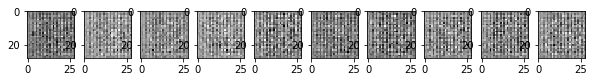

Epochs 0/5: Generator Loss: 1.182. Discriminator Loss: 0.376
Epochs 0/5: Generator Loss: 1.469. Discriminator Loss: 0.267
Epochs 0/5: Generator Loss: 1.651. Discriminator Loss: 0.219
Epochs 0/5: Generator Loss: 1.75. Discriminator Loss: 0.2
Epochs 0/5: Generator Loss: 1.796. Discriminator Loss: 0.19
Epochs 0/5: Generator Loss: 1.842. Discriminator Loss: 0.182
Epochs 0/5: Generator Loss: 1.893. Discriminator Loss: 0.176
Epochs 0/5: Generator Loss: 1.939. Discriminator Loss: 0.165
Epochs 0/5: Generator Loss: 1.947. Discriminator Loss: 0.163
Epochs 0/5: Generator Loss: 2.006. Discriminator Loss: 0.162


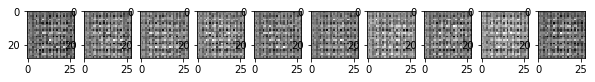

Epochs 0/5: Generator Loss: 1.997. Discriminator Loss: 0.159
Epochs 0/5: Generator Loss: 2.048. Discriminator Loss: 0.148
Epochs 0/5: Generator Loss: 2.048. Discriminator Loss: 0.157
Epochs 0/5: Generator Loss: 2.115. Discriminator Loss: 0.145
Epochs 0/5: Generator Loss: 2.142. Discriminator Loss: 0.156
Epochs 0/5: Generator Loss: 2.183. Discriminator Loss: 0.14
Epochs 0/5: Generator Loss: 2.231. Discriminator Loss: 0.121
Epochs 0/5: Generator Loss: 2.238. Discriminator Loss: 0.126
Epochs 0/5: Generator Loss: 2.227. Discriminator Loss: 0.125
Epochs 0/5: Generator Loss: 2.23. Discriminator Loss: 0.13


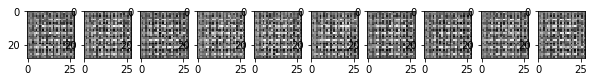

Epochs 0/5: Generator Loss: 2.175. Discriminator Loss: 0.136
Epochs 0/5: Generator Loss: 2.271. Discriminator Loss: 0.128
Epochs 0/5: Generator Loss: 2.194. Discriminator Loss: 0.133
Epochs 0/5: Generator Loss: 2.269. Discriminator Loss: 0.125
Epochs 0/5: Generator Loss: 2.252. Discriminator Loss: 0.131
Epochs 0/5: Generator Loss: 2.312. Discriminator Loss: 0.115
Epochs 0/5: Generator Loss: 2.418. Discriminator Loss: 0.104
Epochs 0/5: Generator Loss: 2.331. Discriminator Loss: 0.129
Epochs 0/5: Generator Loss: 2.324. Discriminator Loss: 0.115
Epochs 0/5: Generator Loss: 2.408. Discriminator Loss: 0.106


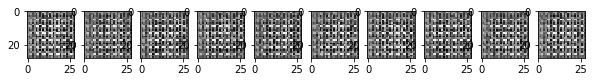

Epochs 0/5: Generator Loss: 2.372. Discriminator Loss: 0.111
Epochs 0/5: Generator Loss: 2.415. Discriminator Loss: 0.115
Epochs 0/5: Generator Loss: 2.385. Discriminator Loss: 0.117
Epochs 0/5: Generator Loss: 2.411. Discriminator Loss: 0.127
Epochs 0/5: Generator Loss: 2.421. Discriminator Loss: 0.111
Epochs 0/5: Generator Loss: 2.448. Discriminator Loss: 0.107
Epochs 0/5: Generator Loss: 2.53. Discriminator Loss: 0.098
Epochs 0/5: Generator Loss: 2.456. Discriminator Loss: 0.101
Epochs 0/5: Generator Loss: 2.524. Discriminator Loss: 0.093
Epochs 0/5: Generator Loss: 2.456. Discriminator Loss: 0.107


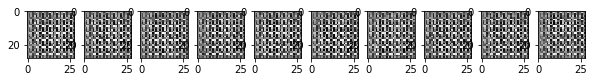

Epochs 0/5: Generator Loss: 2.486. Discriminator Loss: 0.095
Epochs 0/5: Generator Loss: 2.497. Discriminator Loss: 0.11
Epochs 0/5: Generator Loss: 2.538. Discriminator Loss: 0.095
Epochs 0/5: Generator Loss: 2.553. Discriminator Loss: 0.103
Epochs 0/5: Generator Loss: 2.453. Discriminator Loss: 0.111
Epochs 0/5: Generator Loss: 2.373. Discriminator Loss: 0.112
Epochs 0/5: Generator Loss: 2.476. Discriminator Loss: 0.102
Epochs 0/5: Generator Loss: 2.496. Discriminator Loss: 0.097
Epochs 0/5: Generator Loss: 2.52. Discriminator Loss: 0.094
Epochs 0/5: Generator Loss: 2.44. Discriminator Loss: 0.116


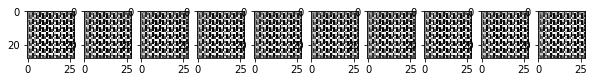

Epochs 0/5: Generator Loss: 2.412. Discriminator Loss: 0.104
Epochs 0/5: Generator Loss: 2.405. Discriminator Loss: 0.111
Epochs 0/5: Generator Loss: 2.399. Discriminator Loss: 0.123
Epochs 0/5: Generator Loss: 2.43. Discriminator Loss: 0.11
Epochs 0/5: Generator Loss: 2.366. Discriminator Loss: 0.117
Epochs 0/5: Generator Loss: 2.305. Discriminator Loss: 0.117
Epochs 0/5: Generator Loss: 2.316. Discriminator Loss: 0.126
Epochs 0/5: Generator Loss: 2.315. Discriminator Loss: 0.116
Epochs 0/5: Generator Loss: 2.403. Discriminator Loss: 0.107
Epochs 0/5: Generator Loss: 2.314. Discriminator Loss: 0.169


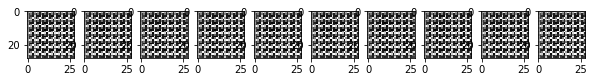

Epochs 0/5: Generator Loss: 2.438. Discriminator Loss: 0.102
Epochs 0/5: Generator Loss: 2.449. Discriminator Loss: 0.109
Epochs 0/5: Generator Loss: 2.534. Discriminator Loss: 0.098
Epochs 0/5: Generator Loss: 2.513. Discriminator Loss: 0.113
Epochs 0/5: Generator Loss: 2.527. Discriminator Loss: 0.103
Epochs 0/5: Generator Loss: 2.46. Discriminator Loss: 0.101
Epochs 0/5: Generator Loss: 2.558. Discriminator Loss: 0.099
Epochs 0/5: Generator Loss: 2.622. Discriminator Loss: 0.091
Epochs 0/5: Generator Loss: 2.707. Discriminator Loss: 0.09
Epochs 0/5: Generator Loss: 2.761. Discriminator Loss: 0.086


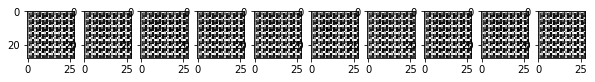

Epochs 0/5: Generator Loss: 2.82. Discriminator Loss: 0.089
Epochs 0/5: Generator Loss: 2.88. Discriminator Loss: 0.091
Epochs 0/5: Generator Loss: 2.972. Discriminator Loss: 0.086
Epochs 0/5: Generator Loss: 3.042. Discriminator Loss: 0.071
Epochs 0/5: Generator Loss: 3.115. Discriminator Loss: 0.072
Epochs 0/5: Generator Loss: 3.156. Discriminator Loss: 0.069
Epochs 0/5: Generator Loss: 3.027. Discriminator Loss: 0.076
Epochs 0/5: Generator Loss: 2.957. Discriminator Loss: 0.088
Epochs 0/5: Generator Loss: 2.94. Discriminator Loss: 0.076
Epochs 0/5: Generator Loss: 2.951. Discriminator Loss: 0.077


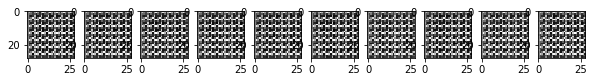

Epochs 0/5: Generator Loss: 2.964. Discriminator Loss: 0.088
Epochs 0/5: Generator Loss: 3.042. Discriminator Loss: 0.07
Epochs 0/5: Generator Loss: 3.048. Discriminator Loss: 0.066
Epochs 0/5: Generator Loss: 3.08. Discriminator Loss: 0.068
Epochs 0/5: Generator Loss: 2.971. Discriminator Loss: 0.07
Epochs 0/5: Generator Loss: 2.909. Discriminator Loss: 0.076
Epochs 0/5: Generator Loss: 2.943. Discriminator Loss: 0.075
Epochs 0/5: Generator Loss: 2.974. Discriminator Loss: 0.071
Epochs 0/5: Generator Loss: 2.875. Discriminator Loss: 0.071
Epochs 0/5: Generator Loss: 2.955. Discriminator Loss: 0.073


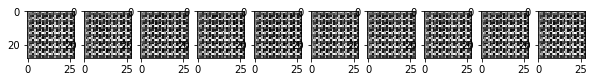

Epochs 0/5: Generator Loss: 2.951. Discriminator Loss: 0.08
Epochs 0/5: Generator Loss: 3.094. Discriminator Loss: 0.074
Epochs 0/5: Generator Loss: 2.994. Discriminator Loss: 0.063
Epochs 1/5: Generator Loss: 2.366. Discriminator Loss: 0.138
Epochs 1/5: Generator Loss: 2.862. Discriminator Loss: 0.083
Epochs 1/5: Generator Loss: 2.963. Discriminator Loss: 0.064
Epochs 1/5: Generator Loss: 3.003. Discriminator Loss: 0.062
Epochs 1/5: Generator Loss: 3.226. Discriminator Loss: 0.052
Epochs 1/5: Generator Loss: 3.227. Discriminator Loss: 0.049
Epochs 1/5: Generator Loss: 3.094. Discriminator Loss: 0.061


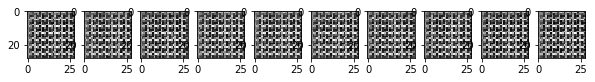

Epochs 1/5: Generator Loss: 3.207. Discriminator Loss: 0.049
Epochs 1/5: Generator Loss: 3.223. Discriminator Loss: 0.045
Epochs 1/5: Generator Loss: 3.185. Discriminator Loss: 0.049
Epochs 1/5: Generator Loss: 3.129. Discriminator Loss: 0.058
Epochs 1/5: Generator Loss: 3.145. Discriminator Loss: 0.053
Epochs 1/5: Generator Loss: 3.278. Discriminator Loss: 0.055
Epochs 1/5: Generator Loss: 3.029. Discriminator Loss: 0.055
Epochs 1/5: Generator Loss: 3.167. Discriminator Loss: 0.056
Epochs 1/5: Generator Loss: 3.105. Discriminator Loss: 0.052
Epochs 1/5: Generator Loss: 3.092. Discriminator Loss: 0.054


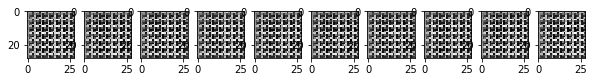

Epochs 1/5: Generator Loss: 3.051. Discriminator Loss: 0.058
Epochs 1/5: Generator Loss: 3.136. Discriminator Loss: 0.049
Epochs 1/5: Generator Loss: 3.036. Discriminator Loss: 0.054
Epochs 1/5: Generator Loss: 3.03. Discriminator Loss: 0.065
Epochs 1/5: Generator Loss: 3.036. Discriminator Loss: 0.056
Epochs 1/5: Generator Loss: 3.207. Discriminator Loss: 0.049
Epochs 1/5: Generator Loss: 3.141. Discriminator Loss: 0.053
Epochs 1/5: Generator Loss: 3.217. Discriminator Loss: 0.055
Epochs 1/5: Generator Loss: 3.293. Discriminator Loss: 0.047
Epochs 1/5: Generator Loss: 3.475. Discriminator Loss: 0.049


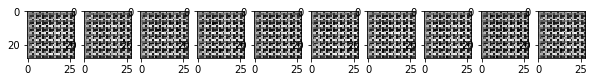

Epochs 1/5: Generator Loss: 3.523. Discriminator Loss: 0.039
Epochs 1/5: Generator Loss: 3.402. Discriminator Loss: 0.038
Epochs 1/5: Generator Loss: 3.138. Discriminator Loss: 0.051
Epochs 1/5: Generator Loss: 3.328. Discriminator Loss: 0.051
Epochs 1/5: Generator Loss: 3.567. Discriminator Loss: 0.042
Epochs 1/5: Generator Loss: 3.422. Discriminator Loss: 0.038
Epochs 1/5: Generator Loss: 3.442. Discriminator Loss: 0.038
Epochs 1/5: Generator Loss: 3.361. Discriminator Loss: 0.048
Epochs 1/5: Generator Loss: 3.359. Discriminator Loss: 0.041
Epochs 1/5: Generator Loss: 3.296. Discriminator Loss: 0.047


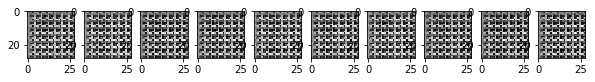

Epochs 1/5: Generator Loss: 3.579. Discriminator Loss: 0.034
Epochs 1/5: Generator Loss: 3.545. Discriminator Loss: 0.037
Epochs 1/5: Generator Loss: 3.439. Discriminator Loss: 0.044
Epochs 1/5: Generator Loss: 3.5. Discriminator Loss: 0.04
Epochs 1/5: Generator Loss: 3.522. Discriminator Loss: 0.041
Epochs 1/5: Generator Loss: 3.594. Discriminator Loss: 0.036
Epochs 1/5: Generator Loss: 3.386. Discriminator Loss: 0.043
Epochs 1/5: Generator Loss: 3.53. Discriminator Loss: 0.038
Epochs 1/5: Generator Loss: 3.407. Discriminator Loss: 0.041
Epochs 1/5: Generator Loss: 3.567. Discriminator Loss: 0.063


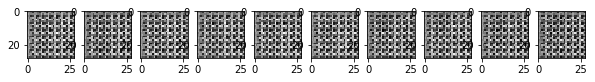

Epochs 1/5: Generator Loss: 3.989. Discriminator Loss: 0.087
Epochs 1/5: Generator Loss: 4.298. Discriminator Loss: 0.069
Epochs 1/5: Generator Loss: 4.255. Discriminator Loss: 0.048
Epochs 1/5: Generator Loss: 4.354. Discriminator Loss: 0.033
Epochs 1/5: Generator Loss: 4.221. Discriminator Loss: 0.065
Epochs 1/5: Generator Loss: 4.419. Discriminator Loss: 0.044
Epochs 1/5: Generator Loss: 4.435. Discriminator Loss: 0.035
Epochs 1/5: Generator Loss: 4.384. Discriminator Loss: 0.022
Epochs 1/5: Generator Loss: 4.246. Discriminator Loss: 0.028
Epochs 1/5: Generator Loss: 4.195. Discriminator Loss: 0.022


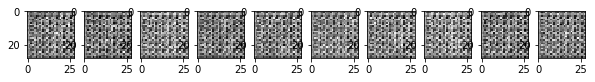

Epochs 1/5: Generator Loss: 4.028. Discriminator Loss: 0.031
Epochs 1/5: Generator Loss: 4.031. Discriminator Loss: 0.025
Epochs 1/5: Generator Loss: 4.272. Discriminator Loss: 0.018
Epochs 1/5: Generator Loss: 4.122. Discriminator Loss: 0.024
Epochs 1/5: Generator Loss: 4.188. Discriminator Loss: 0.02
Epochs 1/5: Generator Loss: 4.123. Discriminator Loss: 0.021
Epochs 1/5: Generator Loss: 4.136. Discriminator Loss: 0.021
Epochs 1/5: Generator Loss: 4.053. Discriminator Loss: 0.022
Epochs 1/5: Generator Loss: 3.836. Discriminator Loss: 0.024
Epochs 1/5: Generator Loss: 3.668. Discriminator Loss: 0.03


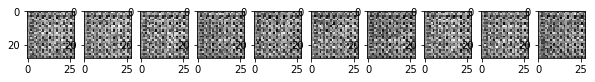

Epochs 1/5: Generator Loss: 3.917. Discriminator Loss: 0.024
Epochs 1/5: Generator Loss: 3.935. Discriminator Loss: 0.024
Epochs 1/5: Generator Loss: 4.027. Discriminator Loss: 0.021
Epochs 1/5: Generator Loss: 4.026. Discriminator Loss: 0.023
Epochs 1/5: Generator Loss: 4.167. Discriminator Loss: 0.018
Epochs 1/5: Generator Loss: 4.124. Discriminator Loss: 0.019
Epochs 1/5: Generator Loss: 4.123. Discriminator Loss: 0.02
Epochs 1/5: Generator Loss: 4.052. Discriminator Loss: 0.021
Epochs 1/5: Generator Loss: 4.064. Discriminator Loss: 0.021
Epochs 1/5: Generator Loss: 4.027. Discriminator Loss: 0.021


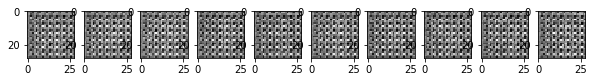

Epochs 1/5: Generator Loss: 3.704. Discriminator Loss: 0.028
Epochs 1/5: Generator Loss: 3.4. Discriminator Loss: 0.039
Epochs 1/5: Generator Loss: 3.706. Discriminator Loss: 0.03
Epochs 1/5: Generator Loss: 3.601. Discriminator Loss: 0.032
Epochs 1/5: Generator Loss: 3.639. Discriminator Loss: 0.03
Epochs 1/5: Generator Loss: 3.694. Discriminator Loss: 0.032
Epochs 1/5: Generator Loss: 3.751. Discriminator Loss: 0.027
Epochs 1/5: Generator Loss: 3.718. Discriminator Loss: 0.027
Epochs 1/5: Generator Loss: 3.633. Discriminator Loss: 0.032
Epochs 1/5: Generator Loss: 3.57. Discriminator Loss: 0.031


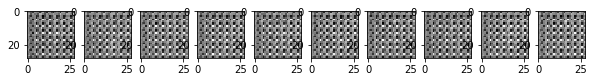

Epochs 1/5: Generator Loss: 3.623. Discriminator Loss: 0.033
Epochs 1/5: Generator Loss: 3.67. Discriminator Loss: 0.031
Epochs 1/5: Generator Loss: 3.506. Discriminator Loss: 0.035
Epochs 1/5: Generator Loss: 3.75. Discriminator Loss: 0.032
Epochs 1/5: Generator Loss: 3.773. Discriminator Loss: 0.028
Epochs 1/5: Generator Loss: 3.838. Discriminator Loss: 0.025
Epochs 1/5: Generator Loss: 3.79. Discriminator Loss: 0.027
Epochs 2/5: Generator Loss: 4.634. Discriminator Loss: 0.209
Epochs 2/5: Generator Loss: 4.828. Discriminator Loss: 0.063
Epochs 2/5: Generator Loss: 4.935. Discriminator Loss: 0.035


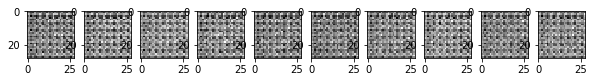

Epochs 2/5: Generator Loss: 4.942. Discriminator Loss: 0.02
Epochs 2/5: Generator Loss: 4.951. Discriminator Loss: 0.017
Epochs 2/5: Generator Loss: 4.708. Discriminator Loss: 0.016
Epochs 2/5: Generator Loss: 4.553. Discriminator Loss: 0.016
Epochs 2/5: Generator Loss: 4.543. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 4.63. Discriminator Loss: 0.016
Epochs 2/5: Generator Loss: 4.407. Discriminator Loss: 0.016
Epochs 2/5: Generator Loss: 4.475. Discriminator Loss: 0.016
Epochs 2/5: Generator Loss: 4.397. Discriminator Loss: 0.019
Epochs 2/5: Generator Loss: 4.656. Discriminator Loss: 0.013


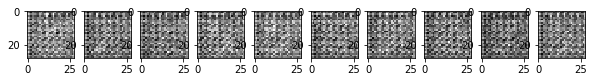

Epochs 2/5: Generator Loss: 4.499. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 4.474. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 4.445. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 4.579. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 4.636. Discriminator Loss: 0.013
Epochs 2/5: Generator Loss: 4.586. Discriminator Loss: 0.012
Epochs 2/5: Generator Loss: 4.535. Discriminator Loss: 0.013
Epochs 2/5: Generator Loss: 4.293. Discriminator Loss: 0.017
Epochs 2/5: Generator Loss: 4.432. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 4.529. Discriminator Loss: 0.013


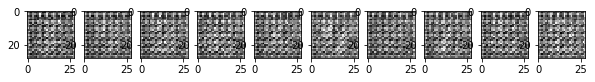

Epochs 2/5: Generator Loss: 4.524. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 4.37. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 4.489. Discriminator Loss: 0.013
Epochs 2/5: Generator Loss: 4.56. Discriminator Loss: 0.013
Epochs 2/5: Generator Loss: 4.665. Discriminator Loss: 0.012
Epochs 2/5: Generator Loss: 4.712. Discriminator Loss: 0.01
Epochs 2/5: Generator Loss: 4.347. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 4.459. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 4.593. Discriminator Loss: 0.012
Epochs 2/5: Generator Loss: 4.348. Discriminator Loss: 0.014


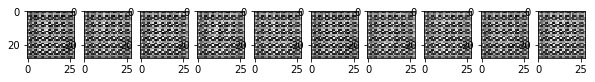

Epochs 2/5: Generator Loss: 4.363. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 4.263. Discriminator Loss: 0.017
Epochs 2/5: Generator Loss: 4.224. Discriminator Loss: 0.016
Epochs 2/5: Generator Loss: 4.166. Discriminator Loss: 0.017
Epochs 2/5: Generator Loss: 4.153. Discriminator Loss: 0.017
Epochs 2/5: Generator Loss: 4.172. Discriminator Loss: 0.018
Epochs 2/5: Generator Loss: 4.017. Discriminator Loss: 0.02
Epochs 2/5: Generator Loss: 3.938. Discriminator Loss: 0.022
Epochs 2/5: Generator Loss: 3.769. Discriminator Loss: 0.026
Epochs 2/5: Generator Loss: 4.019. Discriminator Loss: 0.02


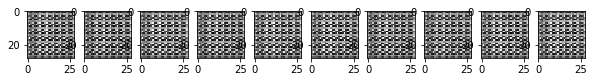

Epochs 2/5: Generator Loss: 3.952. Discriminator Loss: 0.022
Epochs 2/5: Generator Loss: 3.983. Discriminator Loss: 0.021
Epochs 2/5: Generator Loss: 3.937. Discriminator Loss: 0.022
Epochs 2/5: Generator Loss: 4.075. Discriminator Loss: 0.019
Epochs 2/5: Generator Loss: 4.098. Discriminator Loss: 0.018
Epochs 2/5: Generator Loss: 4.053. Discriminator Loss: 0.02
Epochs 2/5: Generator Loss: 4.025. Discriminator Loss: 0.021
Epochs 2/5: Generator Loss: 3.961. Discriminator Loss: 0.021
Epochs 2/5: Generator Loss: 3.993. Discriminator Loss: 0.023
Epochs 2/5: Generator Loss: 4.432. Discriminator Loss: 0.061


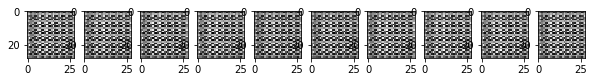

Epochs 2/5: Generator Loss: 5.827. Discriminator Loss: 0.039
Epochs 2/5: Generator Loss: 6.002. Discriminator Loss: 0.034
Epochs 2/5: Generator Loss: 5.948. Discriminator Loss: 0.023
Epochs 2/5: Generator Loss: 6.035. Discriminator Loss: 0.018
Epochs 2/5: Generator Loss: 5.799. Discriminator Loss: 0.018
Epochs 2/5: Generator Loss: 5.745. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 5.404. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 5.399. Discriminator Loss: 0.011
Epochs 2/5: Generator Loss: 5.288. Discriminator Loss: 0.01
Epochs 2/5: Generator Loss: 5.099. Discriminator Loss: 0.01


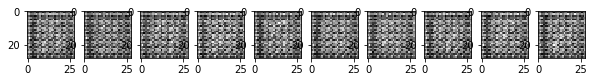

Epochs 2/5: Generator Loss: 5.048. Discriminator Loss: 0.012
Epochs 2/5: Generator Loss: 4.951. Discriminator Loss: 0.011
Epochs 2/5: Generator Loss: 4.666. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 4.651. Discriminator Loss: 0.014
Epochs 2/5: Generator Loss: 4.608. Discriminator Loss: 0.016
Epochs 2/5: Generator Loss: 4.7. Discriminator Loss: 0.015
Epochs 2/5: Generator Loss: 4.079. Discriminator Loss: 0.031
Epochs 2/5: Generator Loss: 4.621. Discriminator Loss: 0.273
Epochs 2/5: Generator Loss: 4.581. Discriminator Loss: 0.022
Epochs 2/5: Generator Loss: 4.043. Discriminator Loss: 0.031


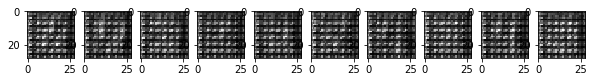

Epochs 2/5: Generator Loss: 3.746. Discriminator Loss: 0.035
Epochs 2/5: Generator Loss: 3.489. Discriminator Loss: 0.04
Epochs 2/5: Generator Loss: 3.592. Discriminator Loss: 0.046
Epochs 2/5: Generator Loss: 3.625. Discriminator Loss: 0.036
Epochs 2/5: Generator Loss: 3.327. Discriminator Loss: 0.049
Epochs 2/5: Generator Loss: 3.247. Discriminator Loss: 0.062
Epochs 2/5: Generator Loss: 3.445. Discriminator Loss: 0.11
Epochs 2/5: Generator Loss: 3.458. Discriminator Loss: 0.107
Epochs 2/5: Generator Loss: 3.853. Discriminator Loss: 0.039
Epochs 2/5: Generator Loss: 3.867. Discriminator Loss: 0.039


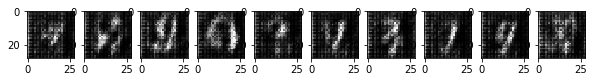

Epochs 2/5: Generator Loss: 3.591. Discriminator Loss: 0.045
Epochs 2/5: Generator Loss: 3.631. Discriminator Loss: 0.037
Epochs 2/5: Generator Loss: 3.276. Discriminator Loss: 0.053
Epochs 2/5: Generator Loss: 3.298. Discriminator Loss: 0.051
Epochs 2/5: Generator Loss: 3.414. Discriminator Loss: 0.048
Epochs 2/5: Generator Loss: 3.059. Discriminator Loss: 0.067
Epochs 2/5: Generator Loss: 3.344. Discriminator Loss: 0.088
Epochs 2/5: Generator Loss: 3.312. Discriminator Loss: 0.062
Epochs 2/5: Generator Loss: 3.396. Discriminator Loss: 0.055
Epochs 2/5: Generator Loss: 3.365. Discriminator Loss: 0.059


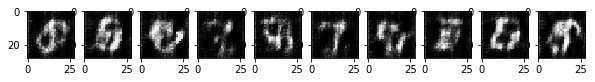

Epochs 2/5: Generator Loss: 3.531. Discriminator Loss: 0.139
Epochs 3/5: Generator Loss: 3.603. Discriminator Loss: 0.071
Epochs 3/5: Generator Loss: 3.15. Discriminator Loss: 0.077
Epochs 3/5: Generator Loss: 3.235. Discriminator Loss: 0.075
Epochs 3/5: Generator Loss: 3.209. Discriminator Loss: 0.073
Epochs 3/5: Generator Loss: 3.313. Discriminator Loss: 0.048
Epochs 3/5: Generator Loss: 3.112. Discriminator Loss: 0.066
Epochs 3/5: Generator Loss: 3.405. Discriminator Loss: 0.102
Epochs 3/5: Generator Loss: 3.781. Discriminator Loss: 0.052
Epochs 3/5: Generator Loss: 3.402. Discriminator Loss: 0.049


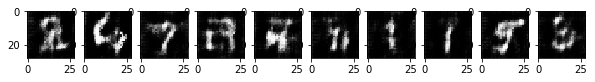

Epochs 3/5: Generator Loss: 3.217. Discriminator Loss: 0.086
Epochs 3/5: Generator Loss: 3.124. Discriminator Loss: 0.061
Epochs 3/5: Generator Loss: 3.262. Discriminator Loss: 0.054
Epochs 3/5: Generator Loss: 3.047. Discriminator Loss: 0.076
Epochs 3/5: Generator Loss: 2.917. Discriminator Loss: 0.079
Epochs 3/5: Generator Loss: 3.216. Discriminator Loss: 0.063
Epochs 3/5: Generator Loss: 3.337. Discriminator Loss: 0.083
Epochs 3/5: Generator Loss: 3.173. Discriminator Loss: 0.054
Epochs 3/5: Generator Loss: 3.295. Discriminator Loss: 0.102
Epochs 3/5: Generator Loss: 2.996. Discriminator Loss: 0.091


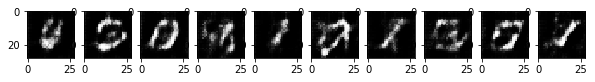

Epochs 3/5: Generator Loss: 3.029. Discriminator Loss: 0.064
Epochs 3/5: Generator Loss: 3.039. Discriminator Loss: 0.067
Epochs 3/5: Generator Loss: 3.187. Discriminator Loss: 0.056
Epochs 3/5: Generator Loss: 2.977. Discriminator Loss: 0.091
Epochs 3/5: Generator Loss: 3.037. Discriminator Loss: 0.092
Epochs 3/5: Generator Loss: 2.978. Discriminator Loss: 0.088
Epochs 3/5: Generator Loss: 3.011. Discriminator Loss: 0.076
Epochs 3/5: Generator Loss: 3.255. Discriminator Loss: 0.114
Epochs 3/5: Generator Loss: 3.708. Discriminator Loss: 0.057
Epochs 3/5: Generator Loss: 3.203. Discriminator Loss: 0.068


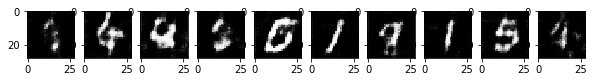

Epochs 3/5: Generator Loss: 3.298. Discriminator Loss: 0.069
Epochs 3/5: Generator Loss: 3.641. Discriminator Loss: 0.125
Epochs 3/5: Generator Loss: 3.493. Discriminator Loss: 0.052
Epochs 3/5: Generator Loss: 3.524. Discriminator Loss: 0.077
Epochs 3/5: Generator Loss: 3.531. Discriminator Loss: 0.046
Epochs 3/5: Generator Loss: 3.2. Discriminator Loss: 0.076
Epochs 3/5: Generator Loss: 3.052. Discriminator Loss: 0.087
Epochs 3/5: Generator Loss: 3.278. Discriminator Loss: 0.063
Epochs 3/5: Generator Loss: 3.05. Discriminator Loss: 0.071
Epochs 3/5: Generator Loss: 3.274. Discriminator Loss: 0.059


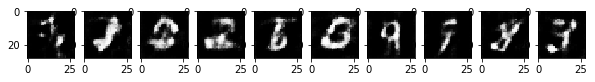

Epochs 3/5: Generator Loss: 3.006. Discriminator Loss: 0.11
Epochs 3/5: Generator Loss: 3.134. Discriminator Loss: 0.082
Epochs 3/5: Generator Loss: 3.02. Discriminator Loss: 0.076
Epochs 3/5: Generator Loss: 3.132. Discriminator Loss: 0.079
Epochs 3/5: Generator Loss: 3.076. Discriminator Loss: 0.069
Epochs 3/5: Generator Loss: 2.747. Discriminator Loss: 0.114
Epochs 3/5: Generator Loss: 2.885. Discriminator Loss: 0.103
Epochs 3/5: Generator Loss: 3.15. Discriminator Loss: 0.079
Epochs 3/5: Generator Loss: 3.396. Discriminator Loss: 0.067
Epochs 3/5: Generator Loss: 3.481. Discriminator Loss: 0.058


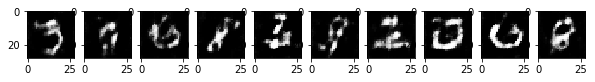

Epochs 3/5: Generator Loss: 3.215. Discriminator Loss: 0.066
Epochs 3/5: Generator Loss: 3.161. Discriminator Loss: 0.076
Epochs 3/5: Generator Loss: 3.377. Discriminator Loss: 0.17
Epochs 3/5: Generator Loss: 3.637. Discriminator Loss: 0.064
Epochs 3/5: Generator Loss: 3.563. Discriminator Loss: 0.051
Epochs 3/5: Generator Loss: 3.569. Discriminator Loss: 0.043
Epochs 3/5: Generator Loss: 3.349. Discriminator Loss: 0.055
Epochs 3/5: Generator Loss: 3.199. Discriminator Loss: 0.058
Epochs 3/5: Generator Loss: 3.139. Discriminator Loss: 0.063
Epochs 3/5: Generator Loss: 2.992. Discriminator Loss: 0.079


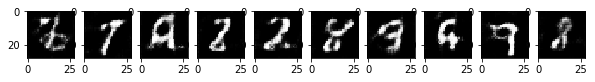

Epochs 3/5: Generator Loss: 3.264. Discriminator Loss: 0.08
Epochs 3/5: Generator Loss: 3.127. Discriminator Loss: 0.108
Epochs 3/5: Generator Loss: 3.364. Discriminator Loss: 0.06
Epochs 3/5: Generator Loss: 3.22. Discriminator Loss: 0.064
Epochs 3/5: Generator Loss: 3.147. Discriminator Loss: 0.073
Epochs 3/5: Generator Loss: 3.087. Discriminator Loss: 0.075
Epochs 3/5: Generator Loss: 2.686. Discriminator Loss: 0.119
Epochs 3/5: Generator Loss: 2.94. Discriminator Loss: 0.091
Epochs 3/5: Generator Loss: 3.1. Discriminator Loss: 0.07
Epochs 3/5: Generator Loss: 3.202. Discriminator Loss: 0.102


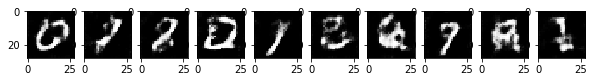

Epochs 3/5: Generator Loss: 3.161. Discriminator Loss: 0.068
Epochs 3/5: Generator Loss: 3.205. Discriminator Loss: 0.063
Epochs 3/5: Generator Loss: 3.508. Discriminator Loss: 0.043
Epochs 3/5: Generator Loss: 3.247. Discriminator Loss: 0.128
Epochs 3/5: Generator Loss: 3.209. Discriminator Loss: 0.121
Epochs 3/5: Generator Loss: 3.386. Discriminator Loss: 0.068
Epochs 3/5: Generator Loss: 3.045. Discriminator Loss: 0.074
Epochs 3/5: Generator Loss: 3.259. Discriminator Loss: 0.053
Epochs 3/5: Generator Loss: 2.931. Discriminator Loss: 0.07
Epochs 3/5: Generator Loss: 2.982. Discriminator Loss: 0.084


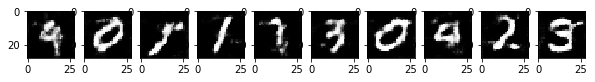

Epochs 3/5: Generator Loss: 3.101. Discriminator Loss: 0.069
Epochs 3/5: Generator Loss: 3.049. Discriminator Loss: 0.078
Epochs 3/5: Generator Loss: 3.161. Discriminator Loss: 0.069
Epochs 3/5: Generator Loss: 3.279. Discriminator Loss: 0.103
Epochs 3/5: Generator Loss: 3.075. Discriminator Loss: 0.064
Epochs 3/5: Generator Loss: 2.873. Discriminator Loss: 0.069
Epochs 3/5: Generator Loss: 3.142. Discriminator Loss: 0.06
Epochs 3/5: Generator Loss: 3.063. Discriminator Loss: 0.084
Epochs 3/5: Generator Loss: 3.467. Discriminator Loss: 0.055
Epochs 3/5: Generator Loss: 3.181. Discriminator Loss: 0.075


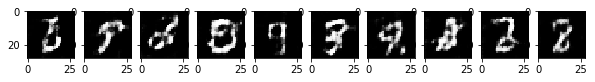

Epochs 3/5: Generator Loss: 3.261. Discriminator Loss: 0.109
Epochs 3/5: Generator Loss: 3.272. Discriminator Loss: 0.061
Epochs 3/5: Generator Loss: 3.204. Discriminator Loss: 0.067
Epochs 3/5: Generator Loss: 3.188. Discriminator Loss: 0.112
Epochs 4/5: Generator Loss: 2.739. Discriminator Loss: 0.376
Epochs 4/5: Generator Loss: 3.409. Discriminator Loss: 0.061
Epochs 4/5: Generator Loss: 3.354. Discriminator Loss: 0.06
Epochs 4/5: Generator Loss: 3.451. Discriminator Loss: 0.053
Epochs 4/5: Generator Loss: 3.417. Discriminator Loss: 0.048
Epochs 4/5: Generator Loss: 3.381. Discriminator Loss: 0.054


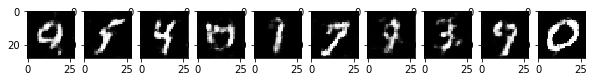

Epochs 4/5: Generator Loss: 3.238. Discriminator Loss: 0.057
Epochs 4/5: Generator Loss: 3.061. Discriminator Loss: 0.07
Epochs 4/5: Generator Loss: 3.425. Discriminator Loss: 0.059


In [ ]:
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
dataset = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

epochs = 5
batch_size = 64
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5
image_type = 'gray'
alpha = 0.2
n_critic = 1

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha, n_critic)